### Exploratory Data Analysis Hints
The notebook covers what is worth checking and doing during EDA step in DS projects.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Data Downloading

In [2]:
data = pd.read_csv(r'../data_sets/bank_churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### EDA

- The fastest and easiest way to plot anything -> use `df.plot()`

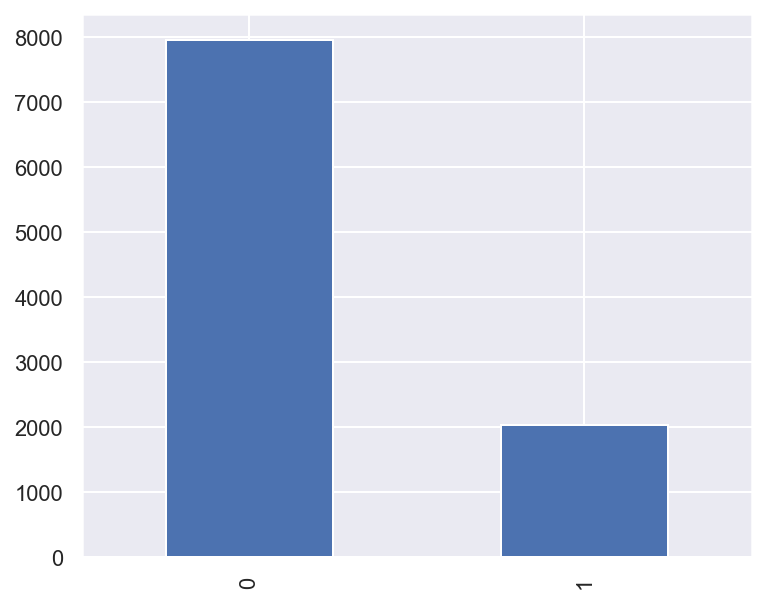

In [3]:
# bar plot
data['Exited'].value_counts().plot(kind='bar', figsize=(6,5));

**Histograms**
- Always important to look at feature distribution
- Two types of distributions can be visualized: histogram and density plot (*Kernel Density Plot*)
- For outliers checking -> box plot is the best (`seaborn` has the best implementation)

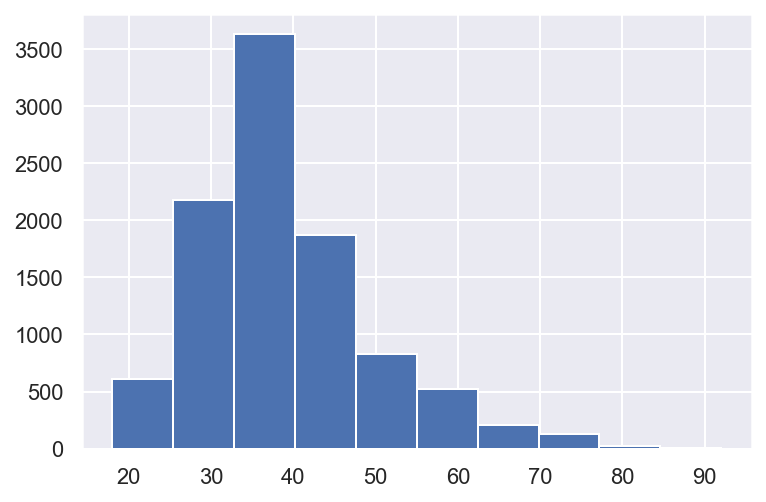

In [4]:
# histogram
data['Age'].hist();

- Histogram issue: need to define number of bins
- Better way to get an idea of feature distribution -> KDE plot

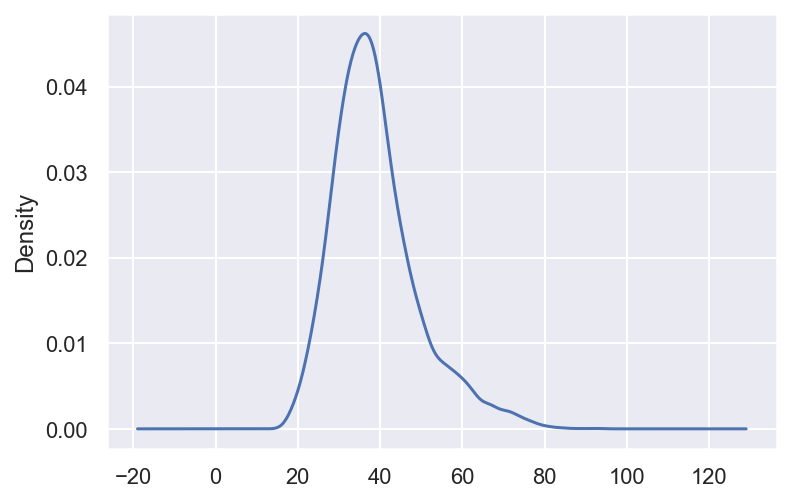

In [5]:
# KDE plot 
data['Age'].plot(kind='density');

- Another option to plot a histogram -> use seaborn 

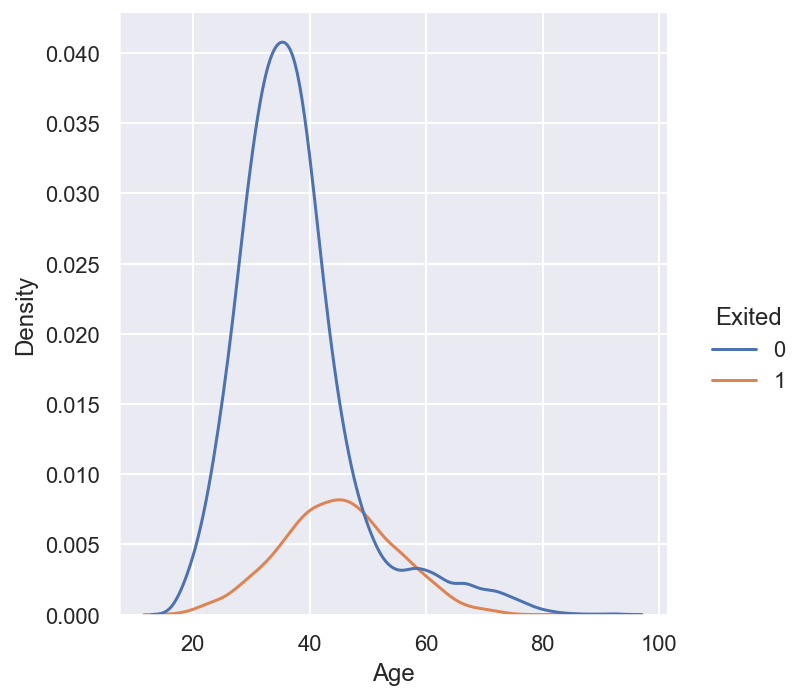

In [64]:
sns.displot(data=data, x='Age', hue="Exited", kind="kde")

**BoxPlot**

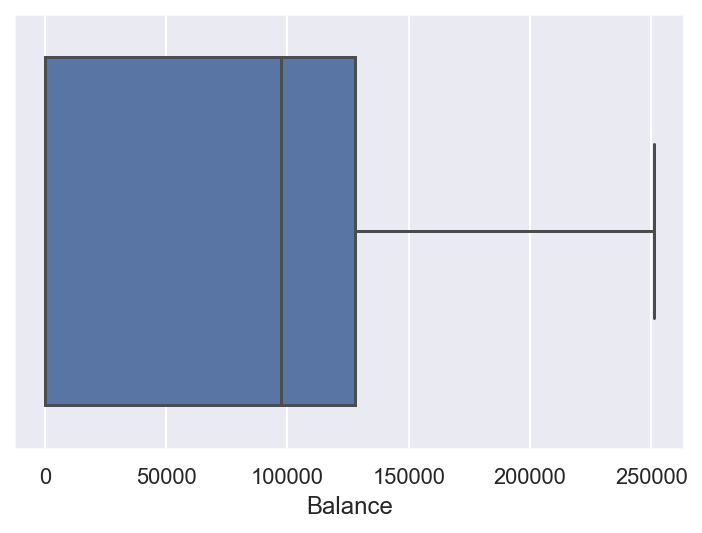

In [7]:
# box plot
sns.boxplot(x="Balance", data=data);

- Sometimes box plots may have no upper or lower whisker -> there are no data points that fall in whisker range
- If we exclude observations with zero balance, boxplot will be better

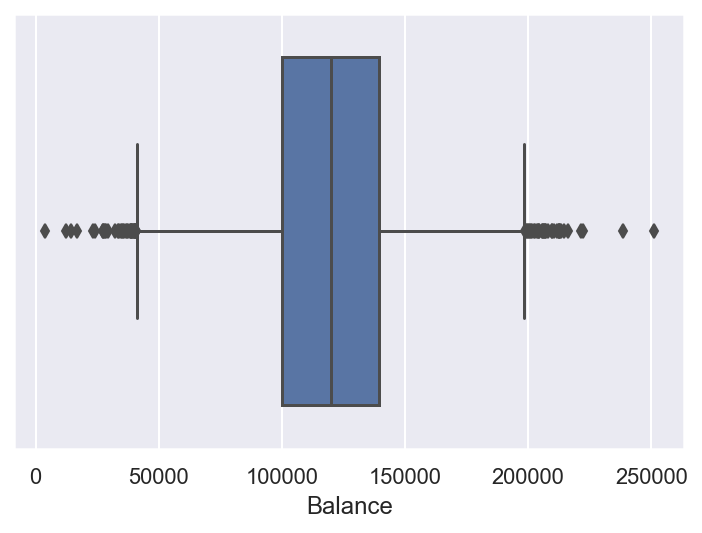

In [8]:
balance_df = data[data['Balance'] != 0][['Balance']]
sns.boxplot(x="Balance", data=balance_df);

- Very useful to look at boxplot distributions in relation to target variable and see how they are different in terms of medians

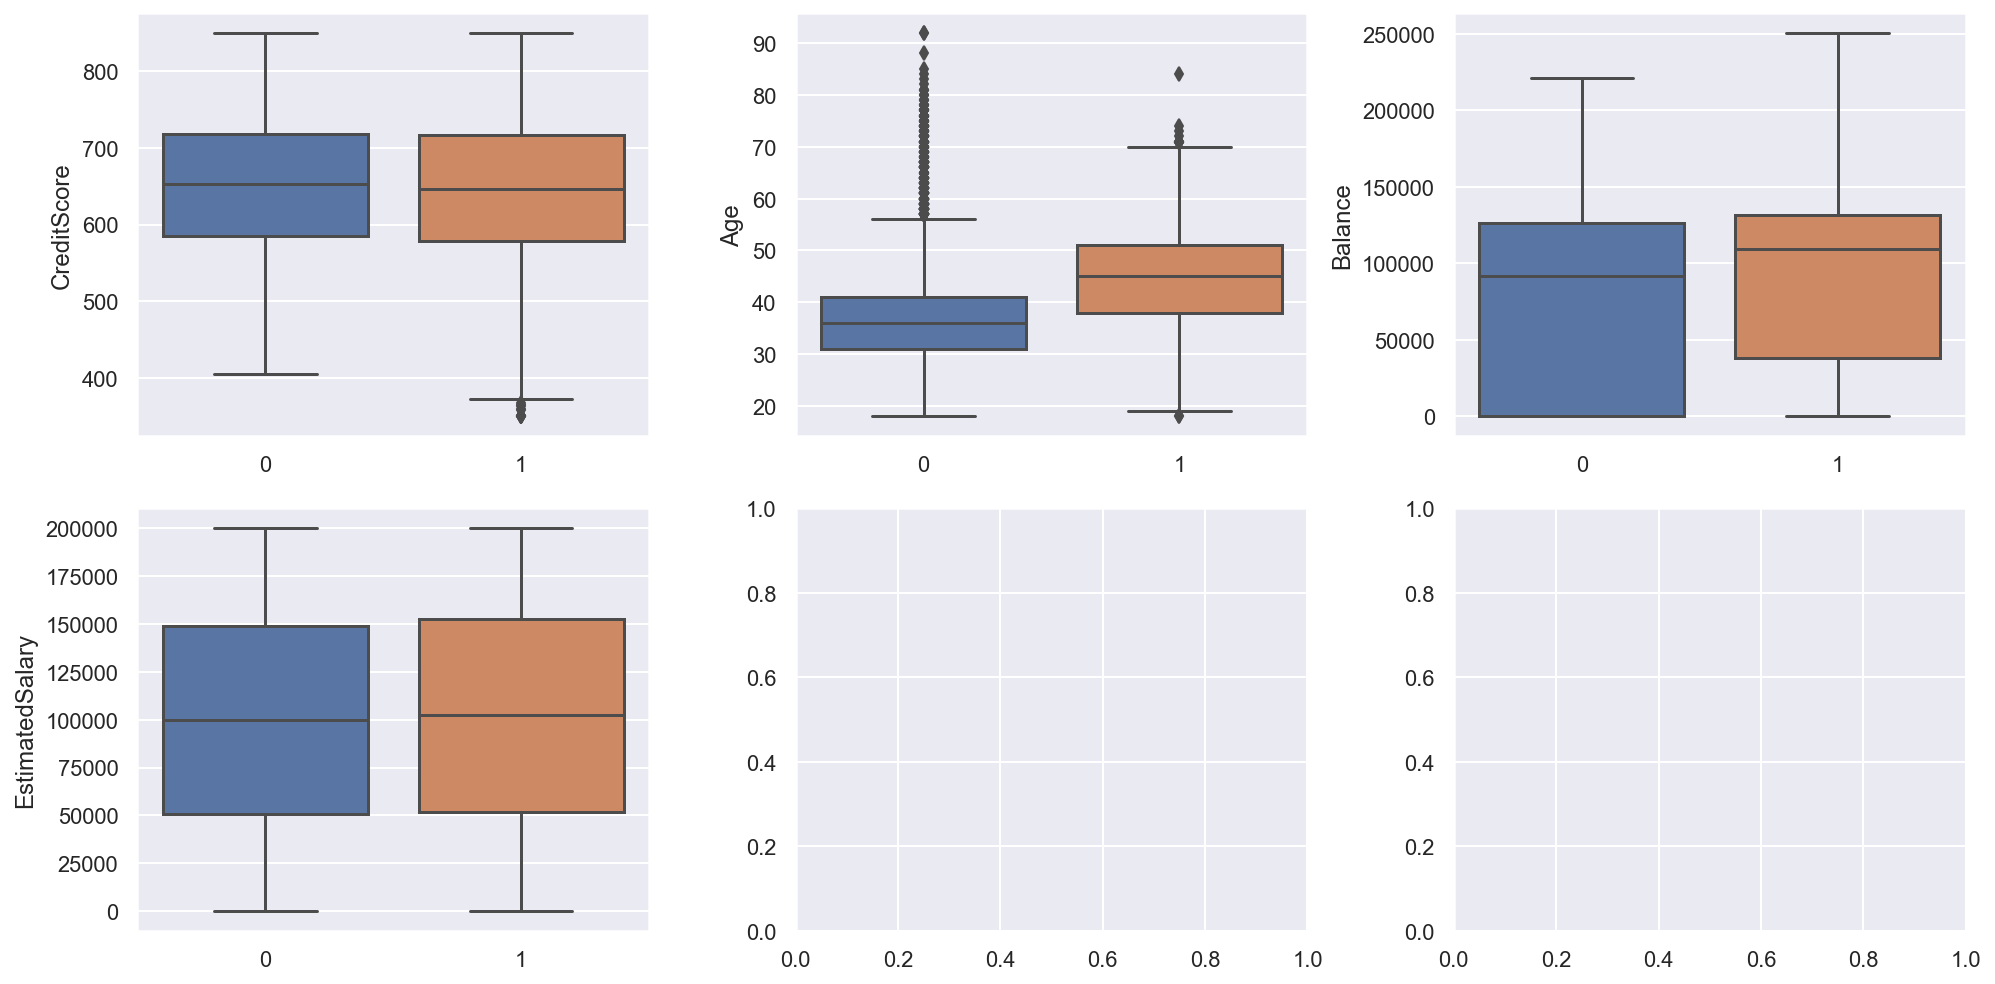

In [9]:
num_columns = [
    'CreditScore',
    'Age',
    'Balance',
    'EstimatedSalary'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
for idx, feat in enumerate(num_columns):
    ax = axes[int(idx / 3), idx % 3]
    sns.boxplot(x="Exited", y=feat, data=data, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)

fig.tight_layout();

- Features that provide the most difference: `Balance`, `Age`

When we want to analyze a quantitative variable in two categorical dimensions at once, there is a suitable function for this in the seaborn library called `catplot()`. For example, let's visualize the interaction between Total day minutes and two categorical variables in the same plot:

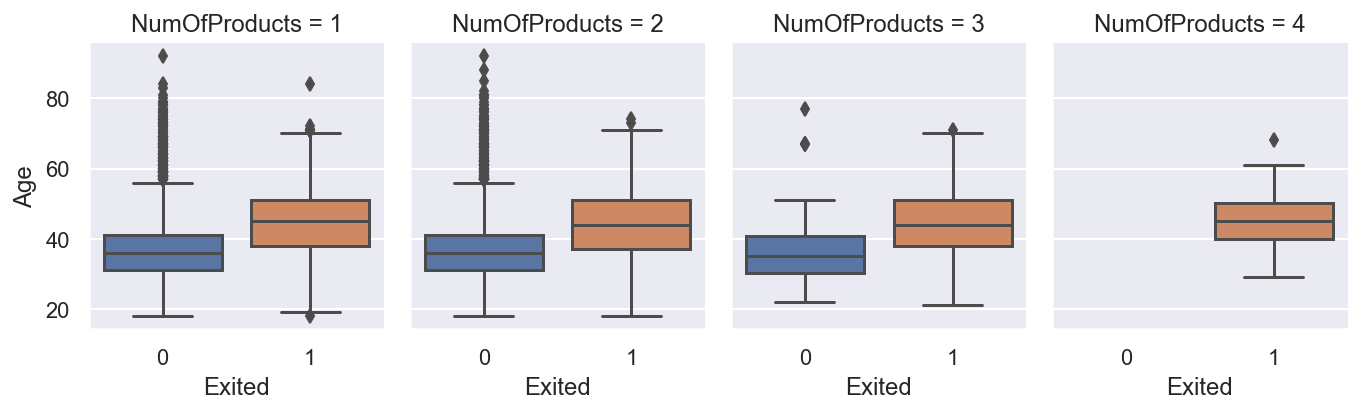

In [10]:
sns.catplot(
    x="Exited",
    y="Age",
    col="NumOfProducts",
    data=data,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8,
);

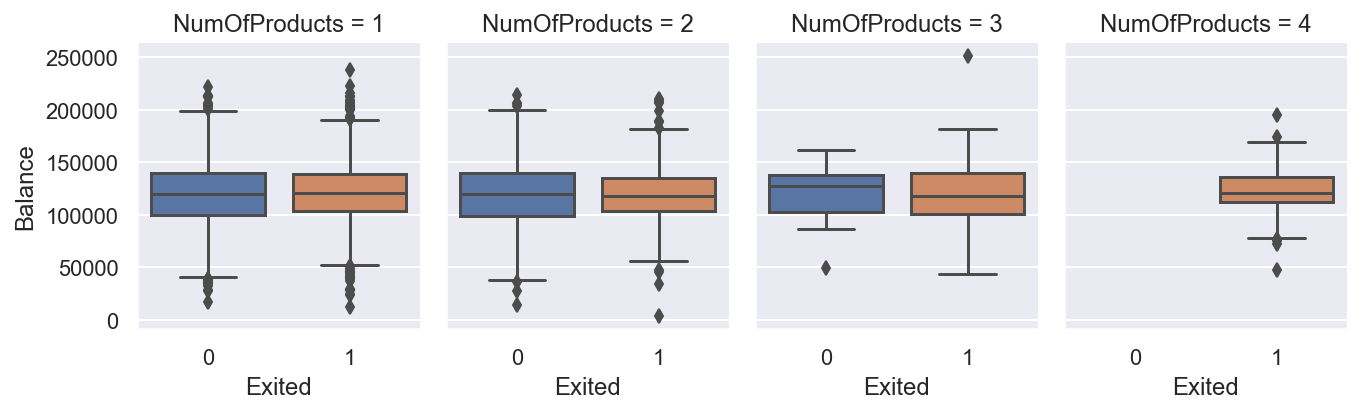

In [11]:
tmp_df = data[data['Balance'] > 0]
sns.catplot(
    x="Exited",
    y="Balance",
    col="NumOfProducts",
    data=tmp_df,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8,
);

**Bar Plot**
- can use either `df.plot` or `sns.countplot`

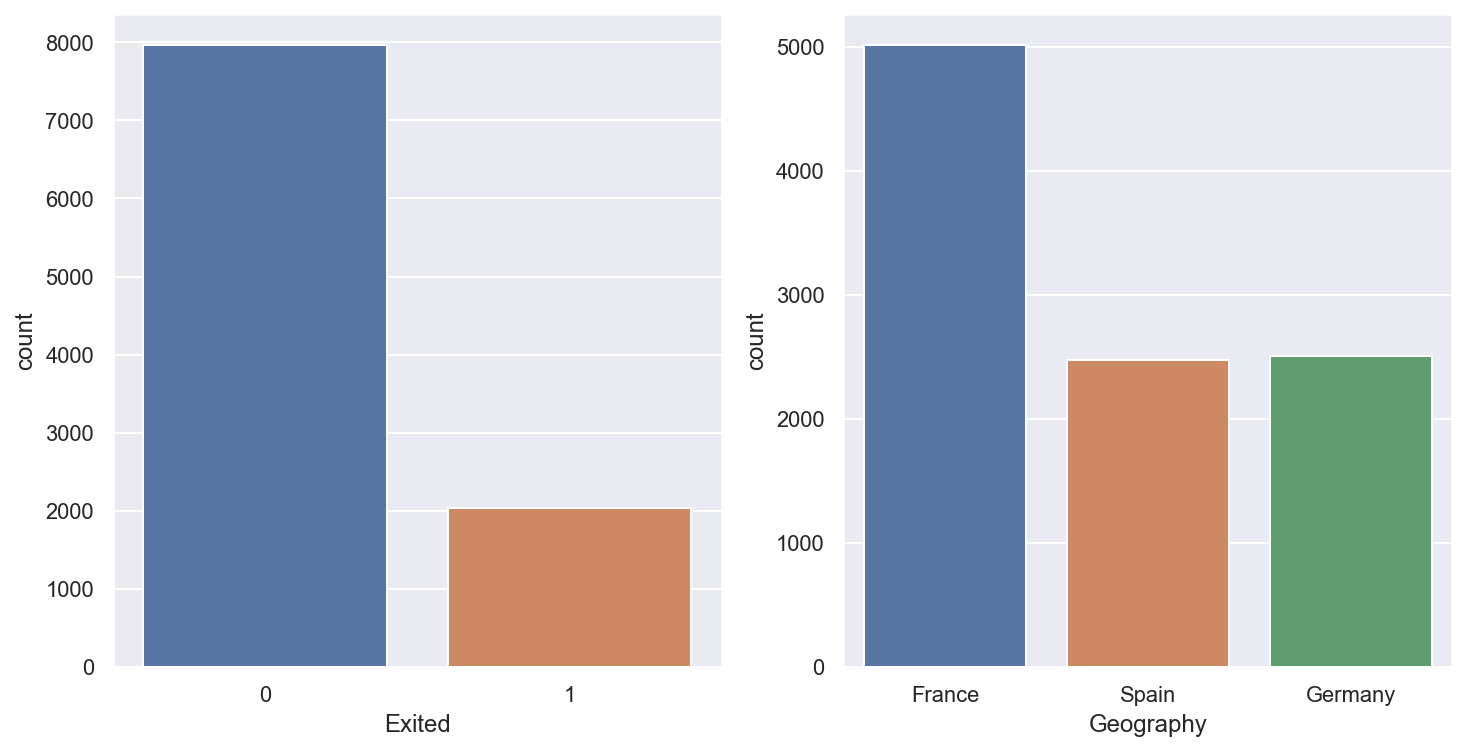

In [12]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.countplot(x="Exited", data=data, ax=axes[0])
sns.countplot(x="Geography", data=data, ax=axes[1]);

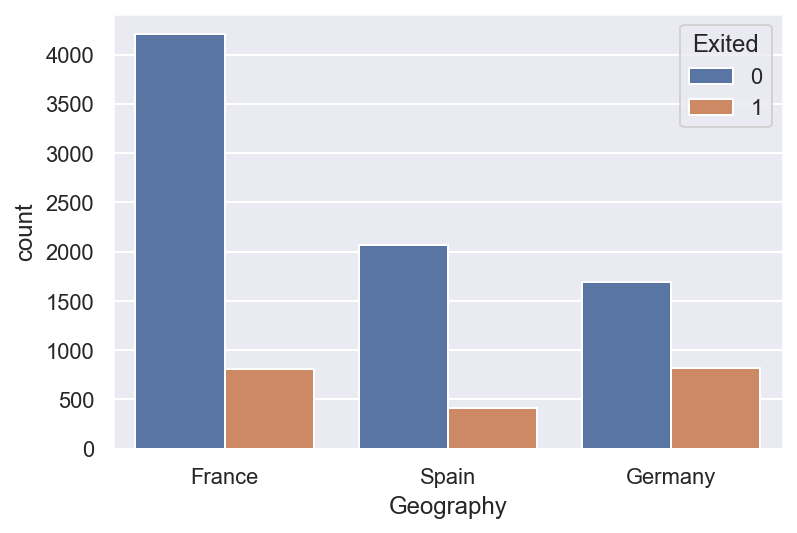

In [13]:
sns.countplot(x="Geography", hue="Exited", data=data);

- Looks like Germany has bigger impact on Churn

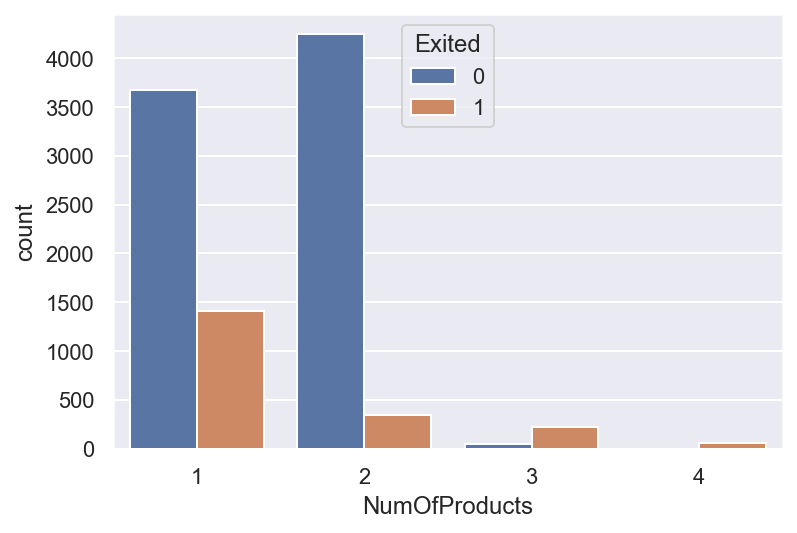

In [14]:
sns.countplot(x="NumOfProducts", hue="Exited", data=data);

- The following number of products lead to churn: 1, 3, 4

**Cross Table**

In addition to using graphical means for categorical analysis, there is a traditional tool from statistics: a contingency table, also called a cross table. It shows a multivariate frequency distribution of categorical variables in tabular form. In particular, it allows us to see the distribution of one variable conditional on the other by looking along a column or row.

In [15]:
# build cross-tab
cross_tab = pd.crosstab(data["NumOfProducts"], data["Exited"]).T
cross_tab_norm = pd.crosstab(data["NumOfProducts"], data["Exited"], normalize=True).T
churn_dist_products = data.groupby(["NumOfProducts"])["Exited"].agg([np.mean]).sort_values(by="mean", ascending=False).T

cross_tab

NumOfProducts,1,2,3,4
Exited,,,,
0,3675,4242,46,0
1,1409,348,220,60


In [16]:
churn_dist_products

NumOfProducts,4,3,1,2
mean,1.0,0.827068,0.277144,0.075817


**Correlation Matrix**

In [17]:
corr_matrix = data[num_columns].corr(method='spearman')
corr_matrix.style.background_gradient(cmap="RdYlGn", vmin=-1, vmax=1)

,CreditScore,Age,Balance,EstimatedSalary
CreditScore,1.000000,-0.007974,0.005687,0.001237
Age,-0.007974,1.000000,0.033304,-0.002431
Balance,0.005687,0.033304,1.000000,0.011778
EstimatedSalary,0.001237,-0.002431,0.011778,1.000000


### Multidimensional Data Representation (t-SNE)

In [18]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [19]:
# preprocess data
cols_to_drop = [
    'RowNumber',
    'CustomerId',
    'Surname',
    'Geography', # requires OHE
]
columns = data.columns[~data.columns.isin(cols_to_drop)]

df = data[columns]
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


In [20]:
# t-SNE requires scaling
X = df.drop(["Exited"], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
%%time

tsne = TSNE(random_state=23)
tsne_repr = tsne.fit_transform(X_scaled)

Wall time: 1min 2s


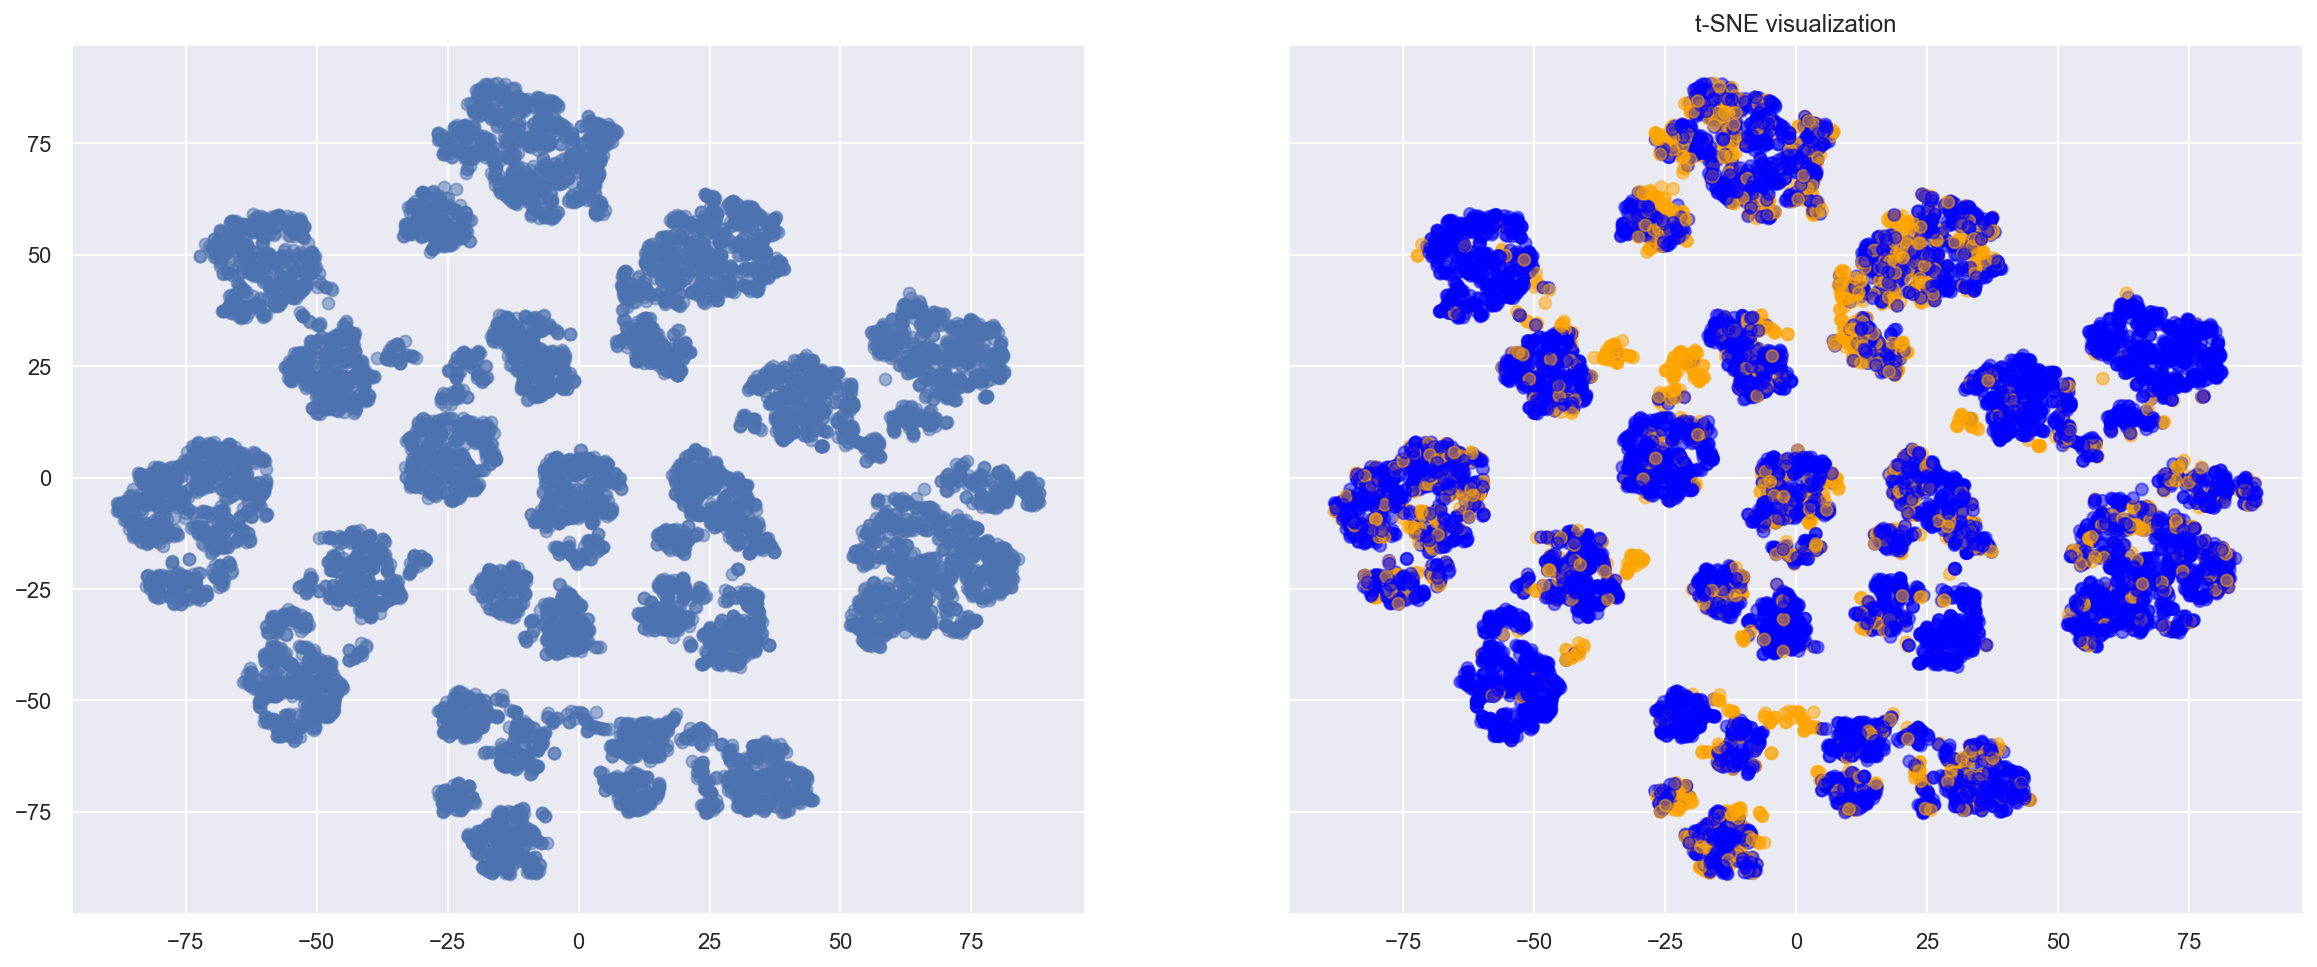

In [33]:
# visualize representation (users representation in feature space)
_, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

axes[0].scatter(tsne_repr[:, 0], tsne_repr[:, 1], alpha=0.5)
axes[1].scatter(tsne_repr[:, 0], tsne_repr[:, 1], c=df["Exited"].map({False: "blue", True: "orange"}),alpha=0.5)

plt.title('t-SNE visualization')
plt.show()

- We can see user clusters and how churn users are distributed across those clusters

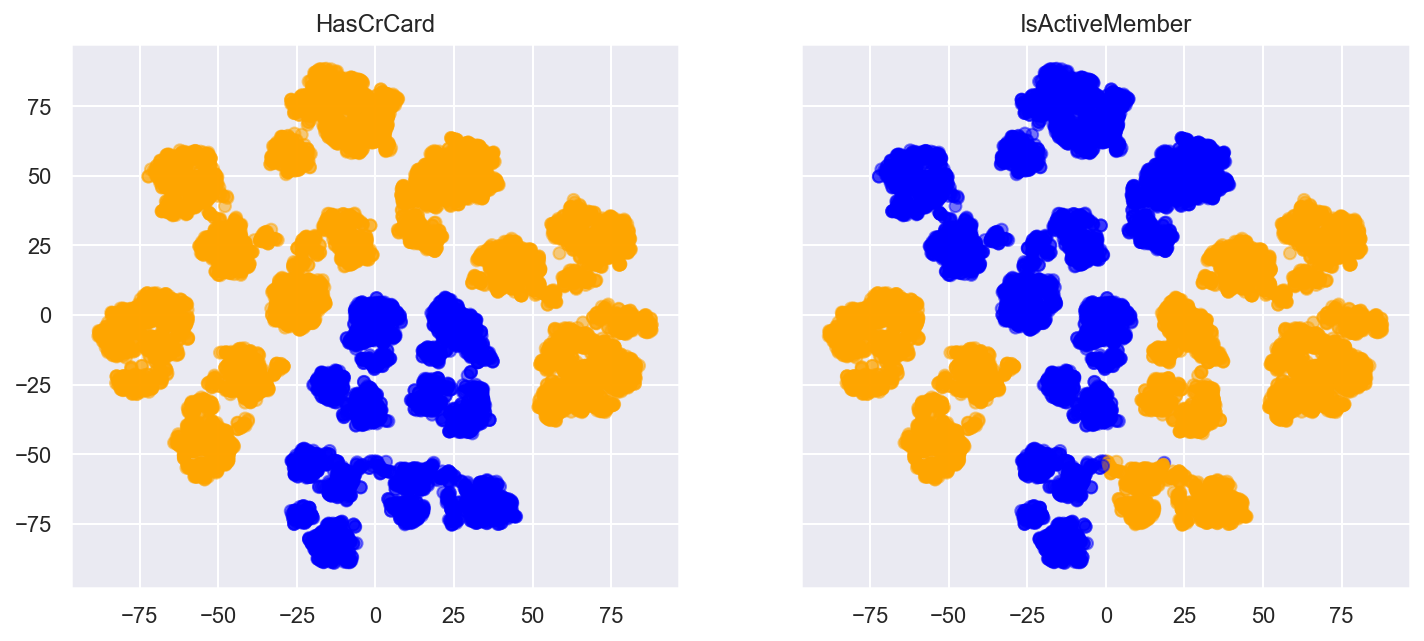

In [39]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

for i, name in enumerate(["HasCrCard", "IsActiveMember"]):
    axes[i].scatter(
        tsne_repr[:, 0],
        tsne_repr[:, 1],
        c=data[name].map({1: "orange", 0: "blue"}),
        alpha=0.5,
    )
    axes[i].set_title(name);